# PF Optimization: HRP vs Markowitz and Equal-Weighted Positions

## Imports & Settings

> This notebook requires the `conda` environment `backtest`. Please see the [installation instructions](../installation/README.md) for running the latest Docker image or alternative ways to set up your environment.

In [1]:
from time import time
import warnings
import sys
import os 

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web

from logbook import (NestedSetup, NullHandler, Logger, 
                     StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,get_datetime,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import KR_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import risk_models
from pypfopt import expected_returns

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [2]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [3]:
os.environ['ZIPLINE_ROOT'] = 'C:/Users/PC/.zipline/'
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

### Logging Setup

In [4]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stdout, format_string=format_string, level=WARNING),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## Algo Params

In [5]:
N_LONGS = 25
MIN_POSITIONS = 20

## Load Data

### Quandl Wiki Bundel

In [6]:
bundle_data = bundles.load('finance_datareader')

### ML Predictions

In [7]:
def load_predictions(bundle):
    path = Path('../../12_gradient_boosting_machines/data')
    predictions = (pd.read_hdf(path / 'predictions.h5', 'lgb/train/01'))
#                    .append(pd.read_hdf(path / 'predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))
                   
    predictions = (predictions.loc[~predictions.index.duplicated()]
                   .iloc[:, :10]
                   .mean(1)
                   .sort_index()
                   .dropna()
                  .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()
    
    assets = []
    for ticker in tickers:
        try:
            asset = bundle.asset_finder.lookup_symbol(ticker, as_of_date=None)
            assets.append(asset)
        except Exception as e:
            print(e) 
            
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [8]:
predictions, assets = load_predictions(bundle_data)

Symbol '000050' was not found.
Symbol '000060' was not found.
Symbol '000070' was not found.
Symbol '000150' was not found.
Symbol '000180' was not found.
Symbol '000230' was not found.
Symbol '000490' was not found.
Symbol '000590' was not found.
Symbol '000640' was not found.
Symbol '000680' was not found.
Symbol '000700' was not found.
Symbol '000890' was not found.
Symbol '001020' was not found.
Symbol '001070' was not found.
Symbol '001200' was not found.
Symbol '001340' was not found.
Symbol '001360' was not found.
Symbol '001380' was not found.
Symbol '001470' was not found.
Symbol '001520' was not found.
Symbol '001630' was not found.
Symbol '001770' was not found.
Symbol '001790' was not found.
Symbol '001800' was not found.
Symbol '001880' was not found.
Symbol '002020' was not found.
Symbol '002030' was not found.
Symbol '002070' was not found.
Symbol '002140' was not found.
Symbol '002150' was not found.
Symbol '002270' was not found.
Symbol '002380' was not found.
Symbol '

In [9]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2014-12-16 00:00:00+00:00 to 2016-12-29 00:00:00+00:00
Columns: 543 entries, 144 to 123690
dtypes: float64(543)
memory usage: 2.1 MB


### Define Custom Dataset

In [10]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = KR_EQUITIES

### Define Pipeline Loaders

In [11]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [12]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [13]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0)
    },
            screen=StaticAssets(assets))

### Get daily Pipeline results

In [14]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')['longs'].astype(int)
    context.longs = output[output!=0].index
    if len(context.longs) < MIN_POSITIONS:
        context.divest = set(context.portfolio.positions.keys())
    else:
        context.divest = context.portfolio.positions.keys() - context.longs

## Define Rebalancing Logic

### Equal Weights

In [15]:
def rebalance_equal_weighted(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        for asset in context.longs:
            order_target_percent(asset, 1/len(context.longs))

### Markowitz Mean-Variance Optimization

In [16]:
def optimize_weights(prices, short=False):
    """Uses PyPortfolioOpt to optimize weights"""
    returns = expected_returns.mean_historical_return(prices=prices, 
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    # get weights that maximize the Sharpe ratio
    # using solver SCS which produces slightly fewer errors than default
    # see https://github.com/robertmartin8/PyPortfolioOpt/issues/221
    ef = EfficientFrontier(expected_returns=returns, 
                           cov_matrix=cov, 
                           weight_bounds=(0, 1),
                           solver='SCS') 
    
    weights = ef.max_sharpe()
    if short:
        return {asset: -weight for asset, weight in ef.clean_weights().items()}
    else:
        return ef.clean_weights()

In [17]:
def rebalance_markowitz(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        prices = data.history(context.longs, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
        try:
            markowitz_weights = optimize_weights(prices)
            for asset, target in markowitz_weights.items():
                order_target_percent(asset=asset, target=target)
        except Exception as e:
            log.warn('{} {}'.format(get_datetime().date(), e))

### Hierarchical Risk Parity

In [18]:
def rebalance_hierarchical_risk_parity(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    Uses PyPortfolioOpt to optimize weights
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        returns = (data.history(context.longs, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
                   .pct_change()
                   .dropna(how='all'))
        hrp_weights = HRPOpt(returns=returns).optimize()
        for asset, target in hrp_weights.items():
            order_target_percent(asset=asset, target=target)

## Record Additional Data Points

Define addtional variables to capture in the results `DataFrame`.

In [19]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs)

## Initialize Algorithm with PF optimization algorithm

Execute `run_algorithm` once with each algorithm:

### Select portfolio optimization algorithm

In [20]:
pf_algos = {
    'ew': rebalance_equal_weighted,
    'markowitz': rebalance_markowitz,        
    'hrp': rebalance_hierarchical_risk_parity
}


In [21]:
# more descriptive labels for plots
algo_labels = {
    'ew': 'Equal Weighted', 
    'markowitz': 'Markowitz (MFT)',
    'hrp': 'Hierarchical Risk Parity'
    }

Here we set the algo we are going to use:

In [101]:
# 하나씩 주석 해제하면서 해보기
# selected_pf_algo = 'hrp'
# selected_pf_algo = 'ew'
selected_pf_algo = 'markowitz'

### Schedule rebalancing using selected algo

In [102]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = 0
    context.pf_algo = pf_algos.get(selected_pf_algo)
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=1))

    schedule_function(context.pf_algo,
                      # run every day after market open
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))    

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

## Run trading algorithm for each PF optimization approach

In [103]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [104]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2014-12-16
End:   2016-12-29


In [105]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='finance_datareader',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[ 04:35:53.007024]: INFO: Simulated 514 trading days
first open: 2014-12-16 14:31:00+00:00
last close: 2016-12-29 21:00:00+00:00
Duration: 21.00s


### Persist experiment results

In [106]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [107]:
with pd.HDFStore('backtests.h5') as store:
    store.put('returns/{}'.format(selected_pf_algo), returns)
    store.put('positions/{}'.format(selected_pf_algo), positions)
    store.put('transactions/{}'.format(selected_pf_algo), transactions)

In [108]:
with pd.HDFStore('backtests.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: backtests.h5
/positions/ew                      frame        (shape->[496,1]) 
/positions/hrp                     frame        (shape->[496,1]) 
/positions/markowitz               frame        (shape->[496,1]) 
/returns/ew                        series       (shape->[514])   
/returns/hrp                       series       (shape->[514])   
/returns/markowitz                 series       (shape->[514])   
/transactions/ew                   frame        (shape->[3682,8])
/transactions/hrp                  frame        (shape->[2965,8])
/transactions/markowitz            frame        (shape->[2161,8])


## Comparing results using pyfolio

Once you're run the three algorithms (or those you're interested in), let's compare the results.

### Load benchmark

In [109]:
benchmark = web.DataReader('^KS11', 'yahoo', '2014', '2020')['Close'].squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC').dropna()

In [110]:
return_index = returns.index

In [111]:
benchmark = benchmark.reindex(index=return_index)

### Cumulative Returns & Rolling Sharpe Ratios

In [112]:
algo_labels.items()

dict_items([('ew', 'Equal Weighted'), ('markowitz', 'Markowitz (MFT)'), ('hrp', 'Hierarchical Risk Parity')])

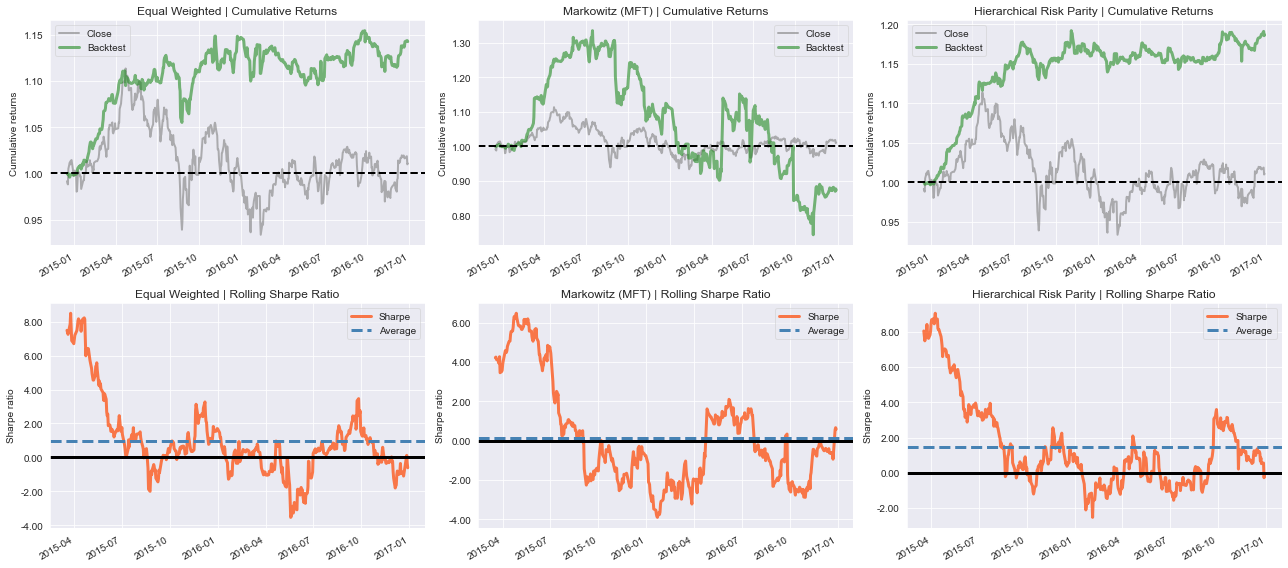

In [113]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))

for i, (algo, label) in enumerate(algo_labels.items()):
    returns = pd.read_hdf('backtests.h5', f'returns/{algo}')    
    plot_rolling_returns(returns,
                         factor_returns=benchmark,
#                          live_start_date='2017-01-01',
                         logy=False,
                         cone_std=2,
                         legend_loc='best',
                         volatility_match=False,
                         cone_function=forecast_cone_bootstrap,
                        ax=axes[0][i])
    plot_rolling_sharpe(returns, ax=axes[1][i], rolling_window=63)
    axes[0][i].set_title(f'{label} | Cumulative Returns')
    axes[1][i].set_title(f'{label} | Rolling Sharpe Ratio')
    fig.tight_layout()

### Tear Sheets

In [114]:
def load_results(experiment='hrp'):
    with pd.HDFStore('backtests.h5') as store:
        returns = store.get('returns/{}'.format(experiment))
        positions = store.get('positions/{}'.format(experiment))
        transactions = store.get('transactions/{}'.format(experiment))
    return returns, positions, transactions

#### Equal Weighted

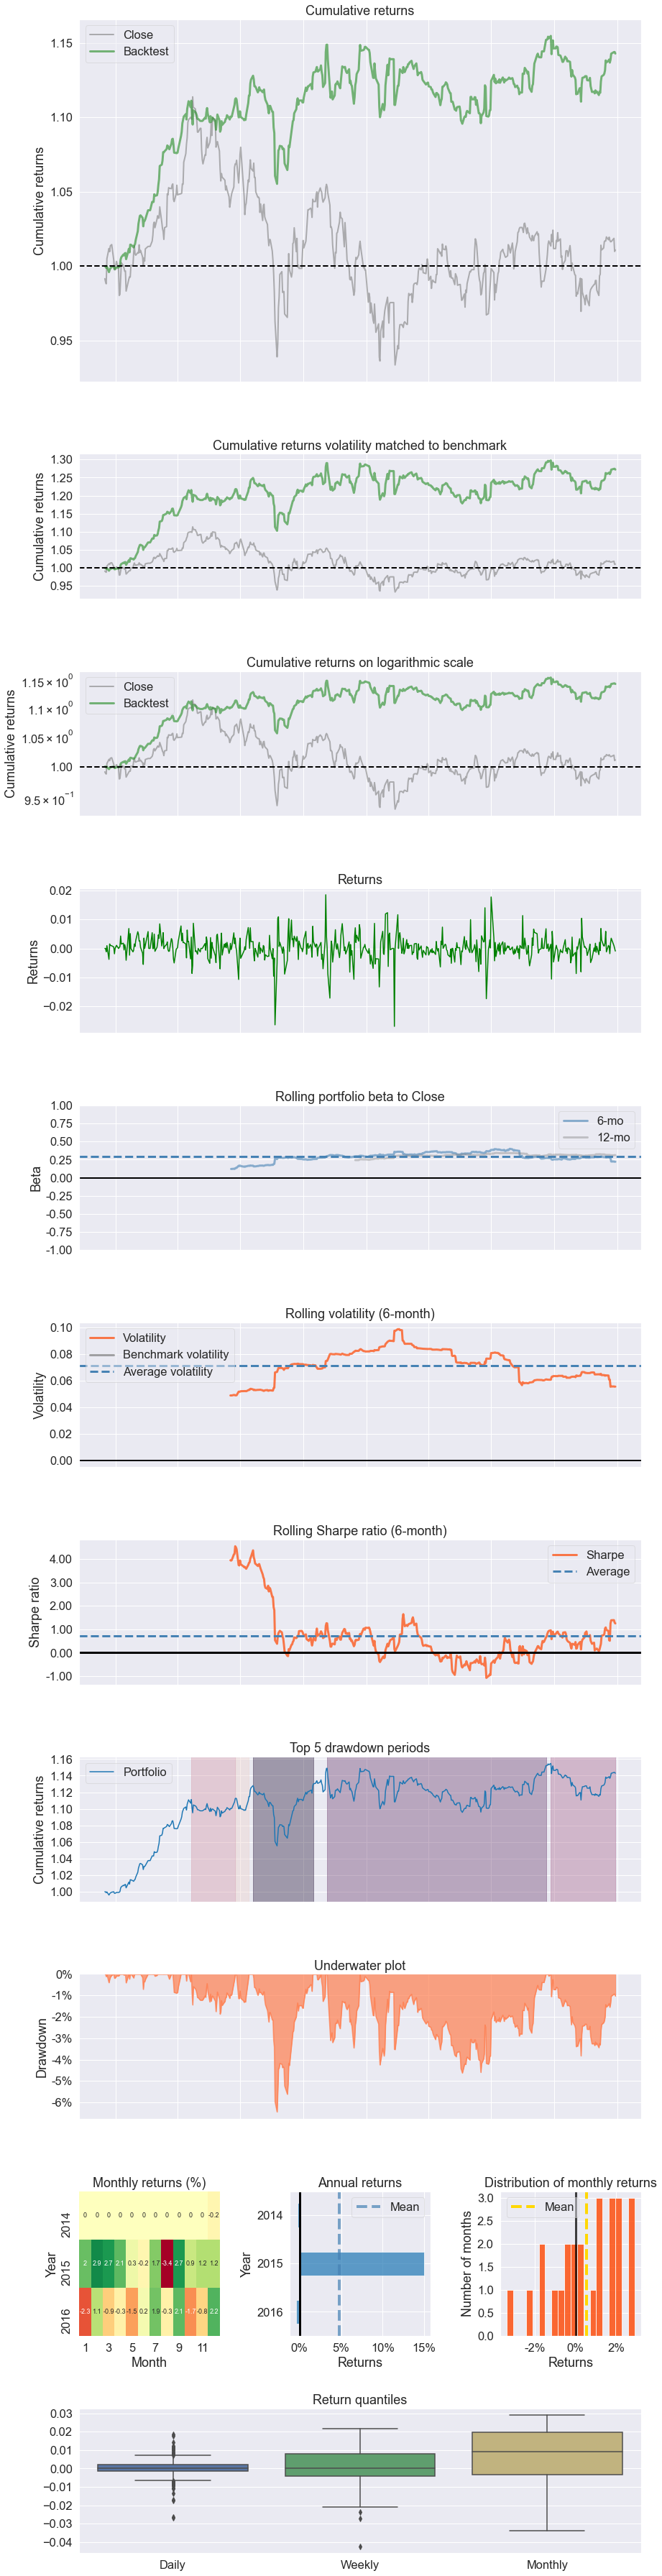

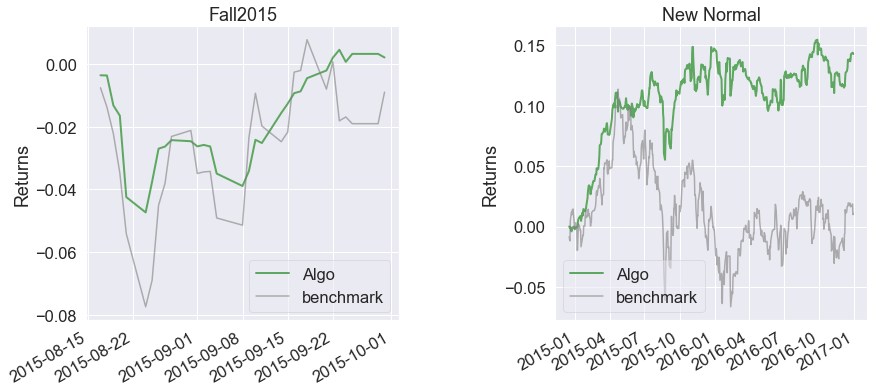

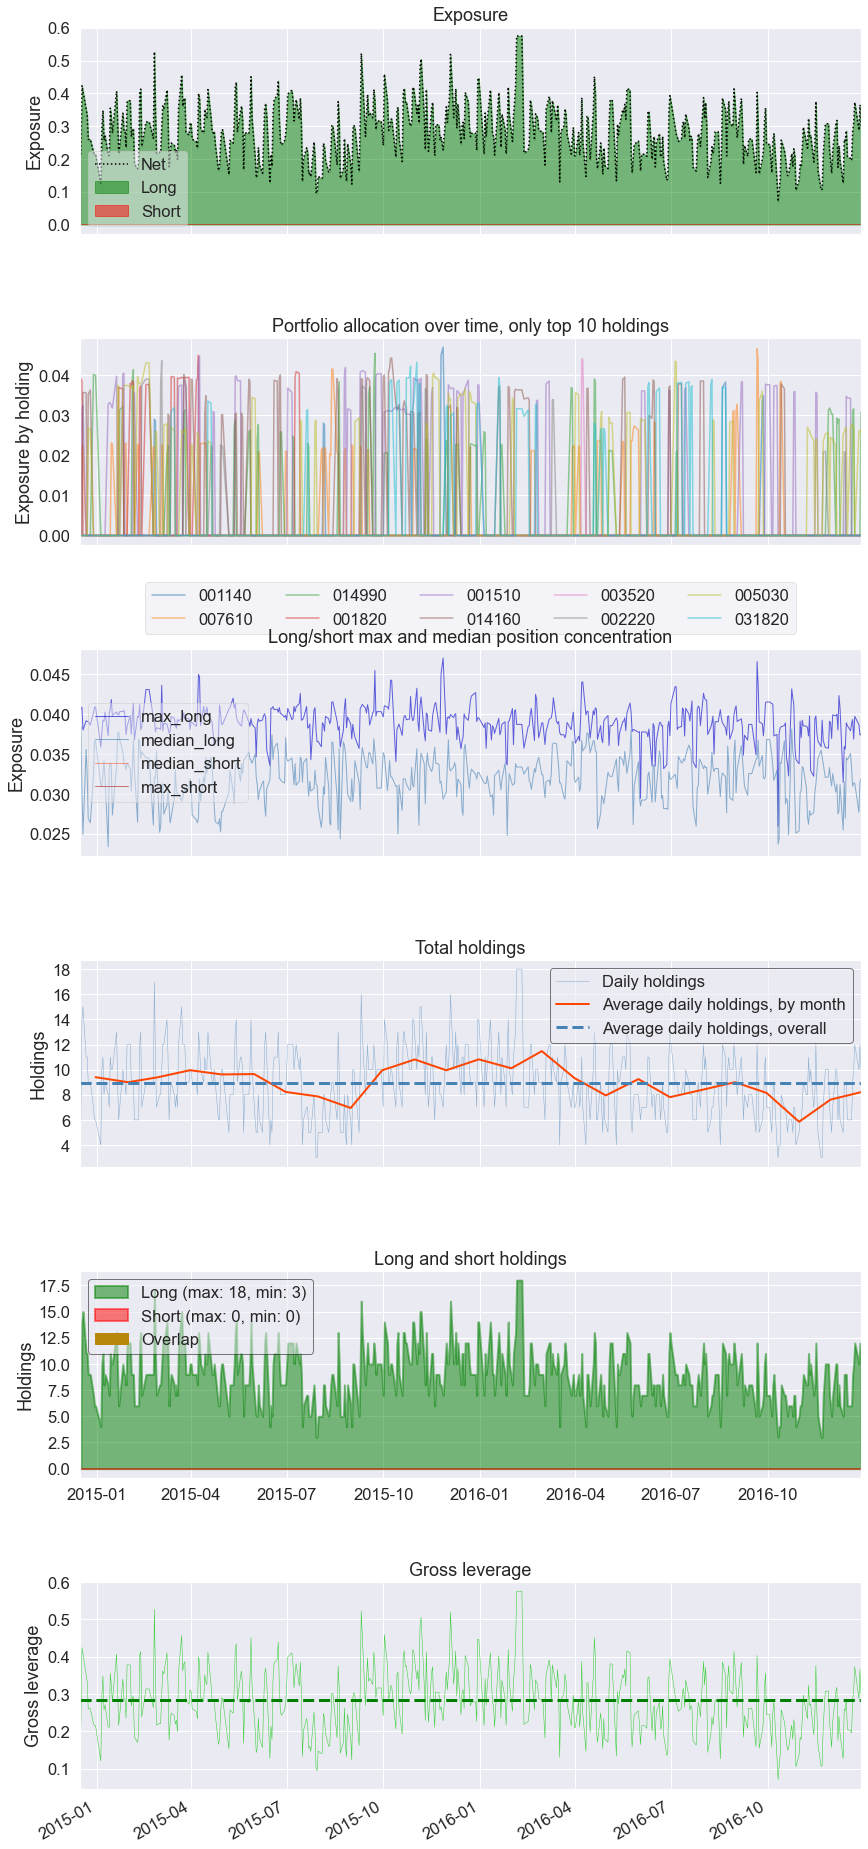

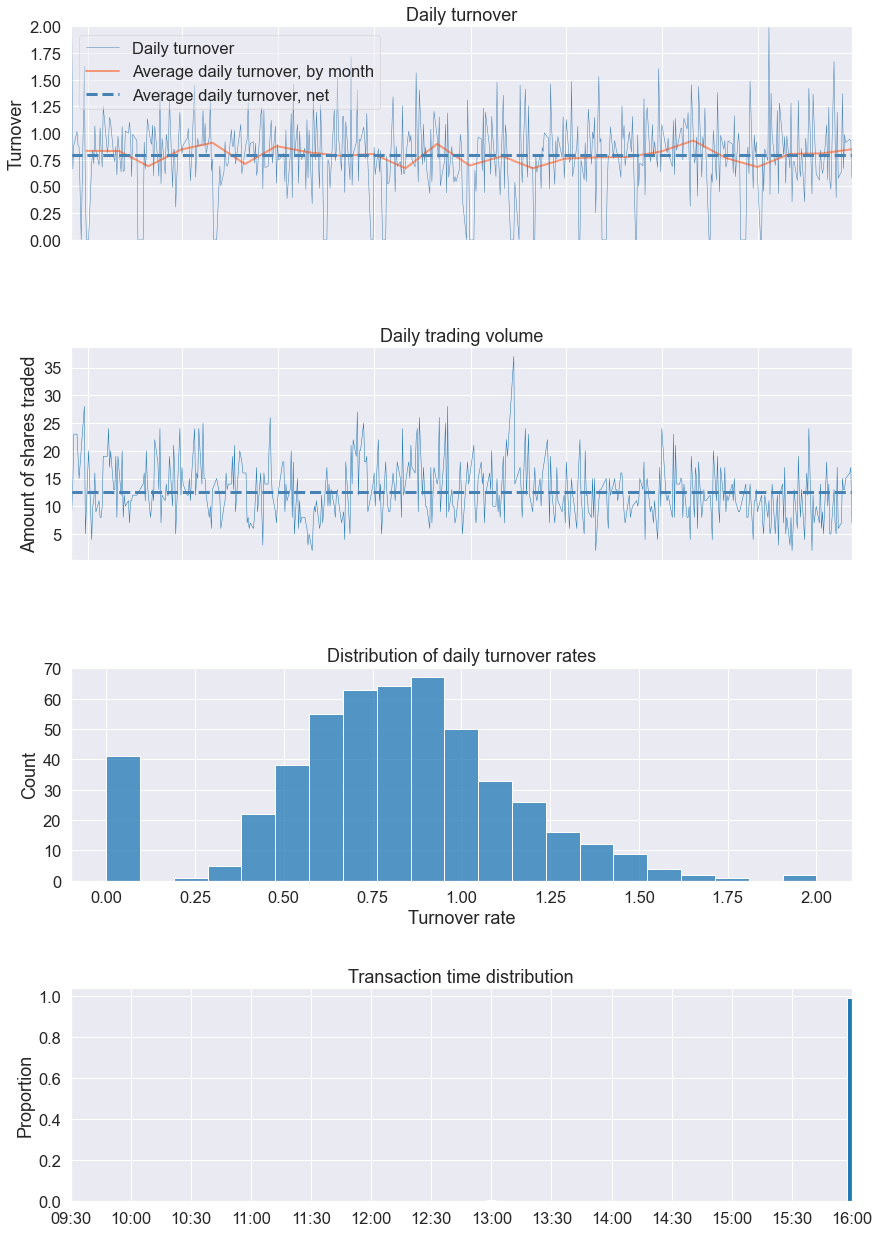

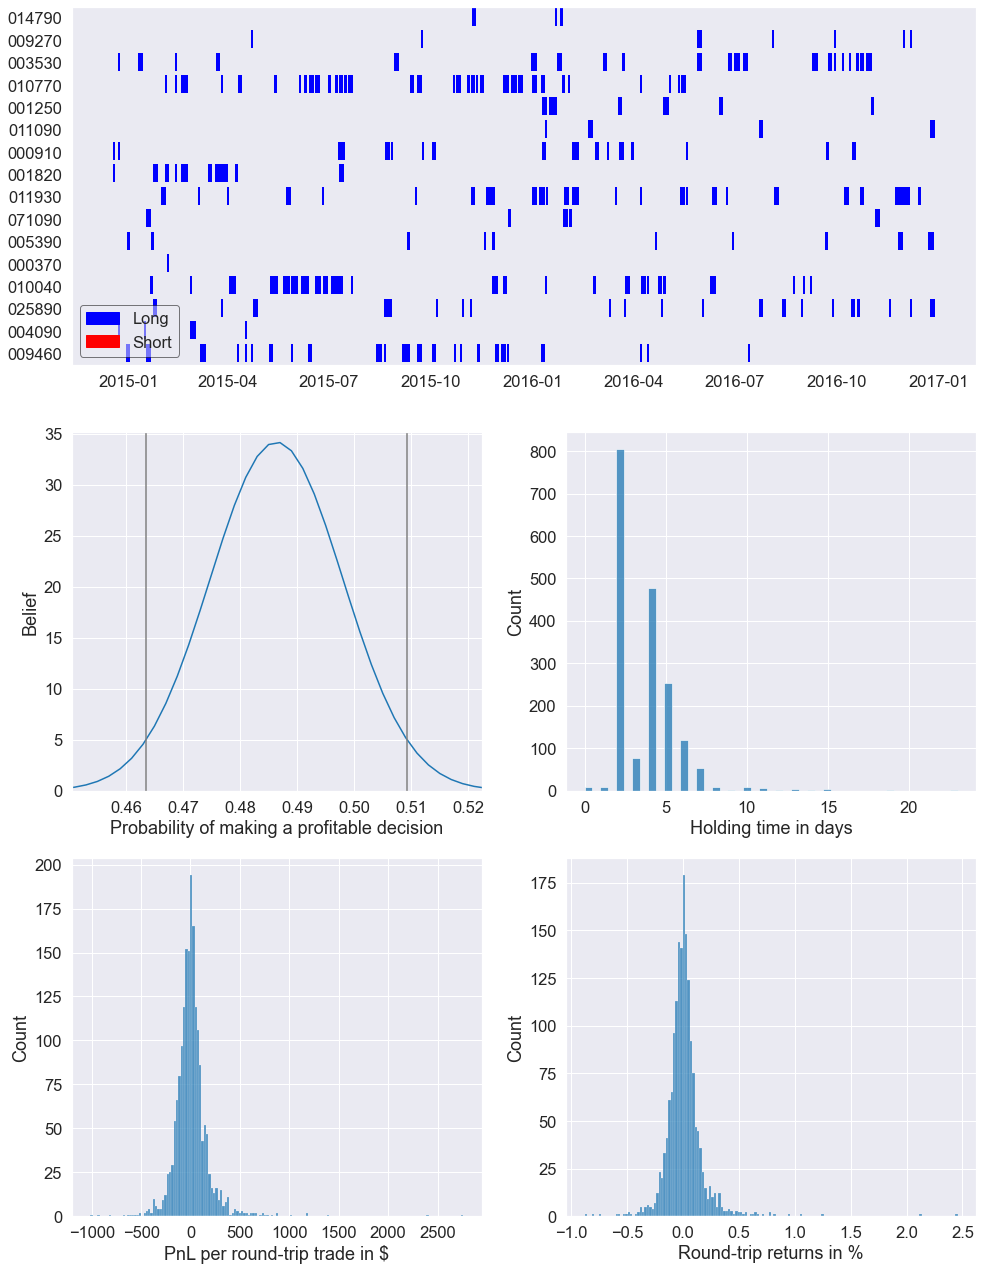

In [117]:
experiment = 'ew'
returns, positions, transactions = load_results(experiment)

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)

#### HRP

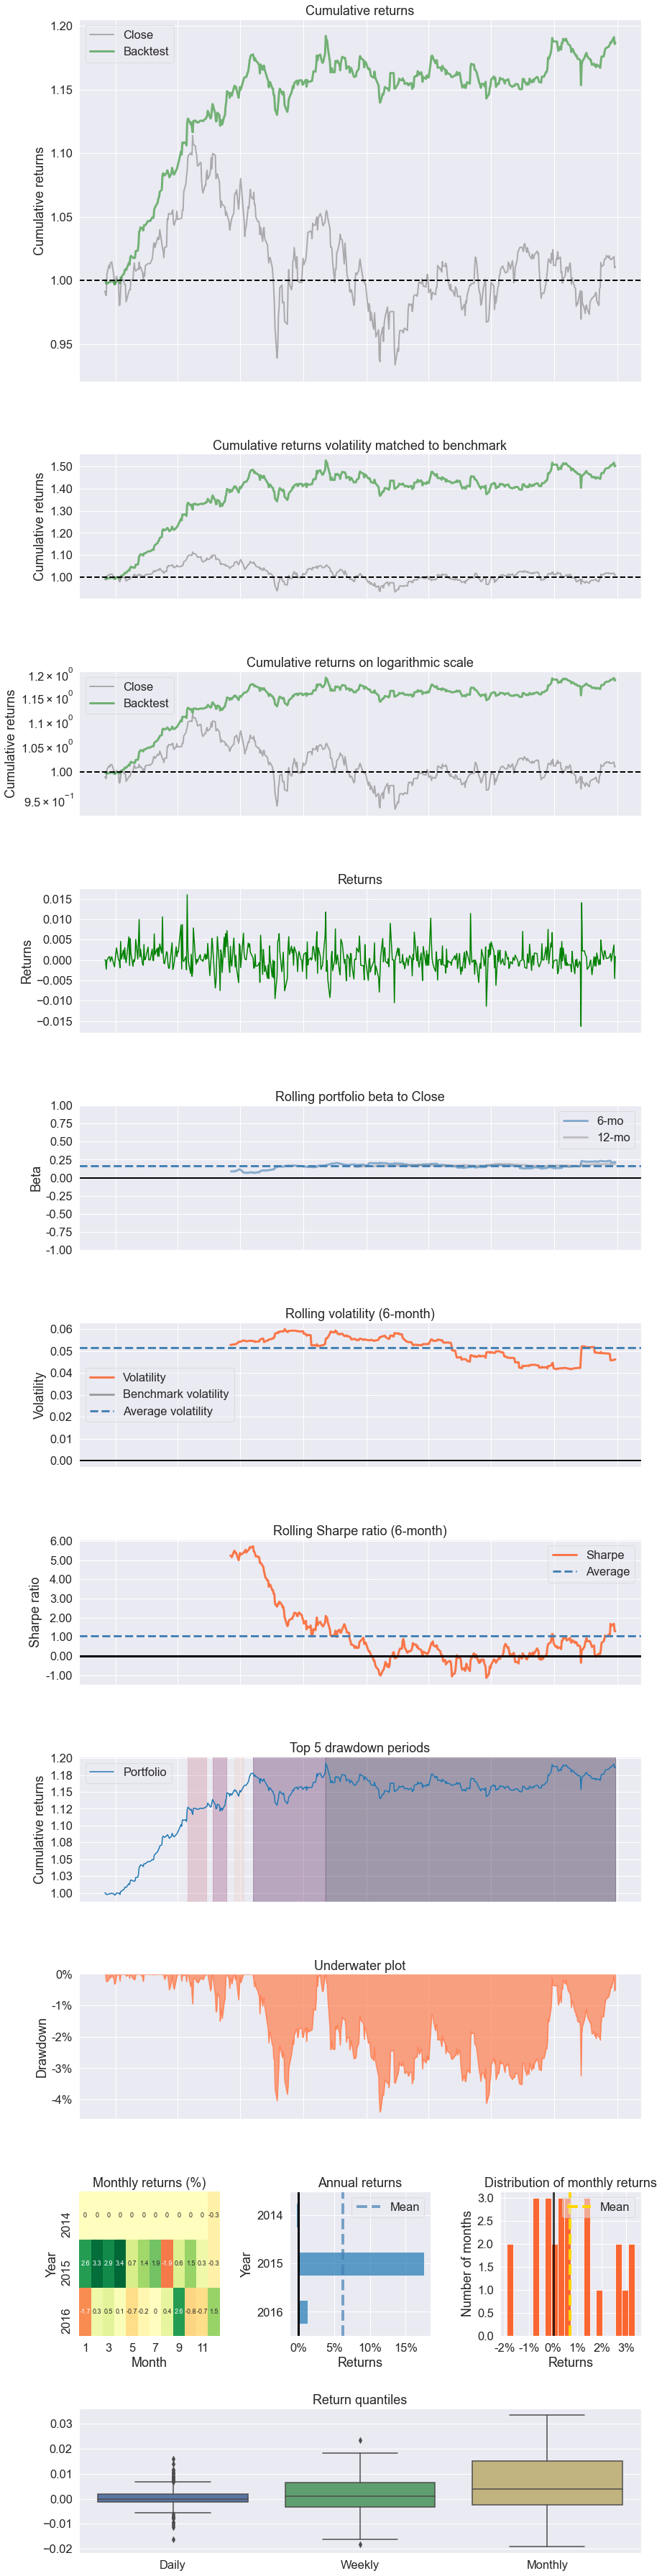

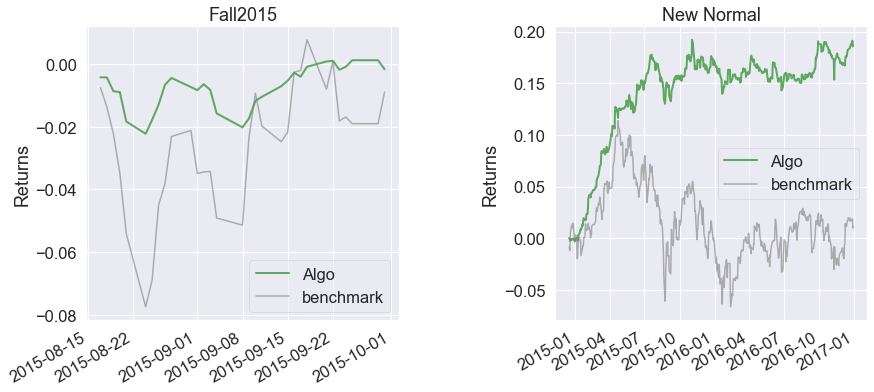

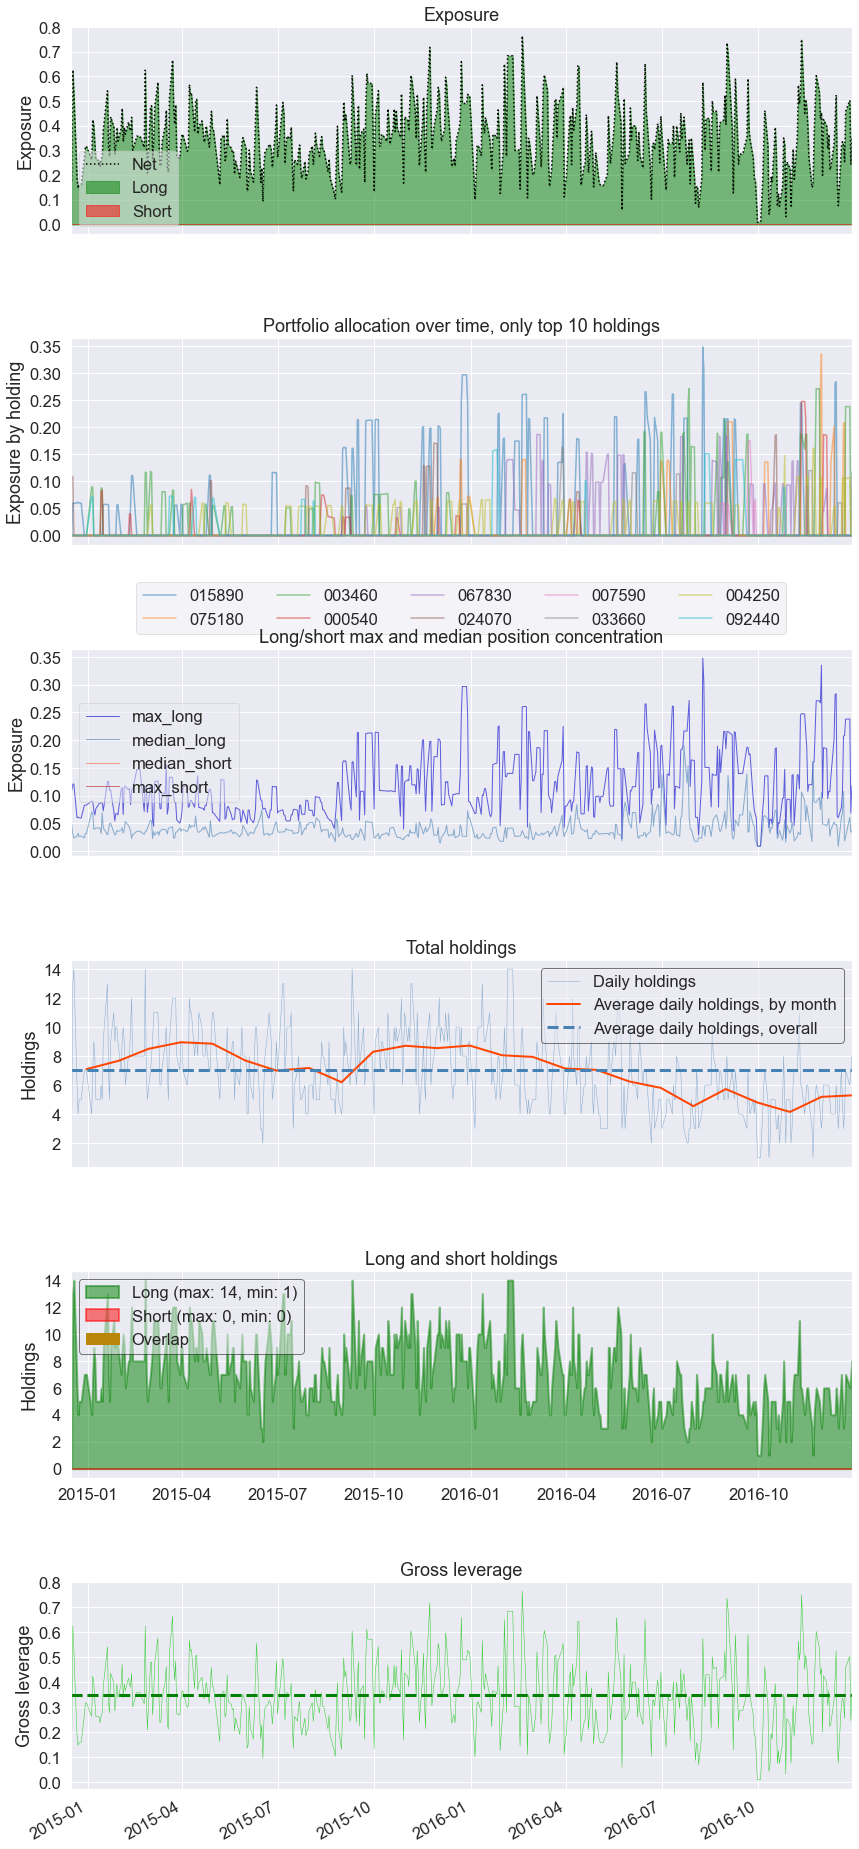

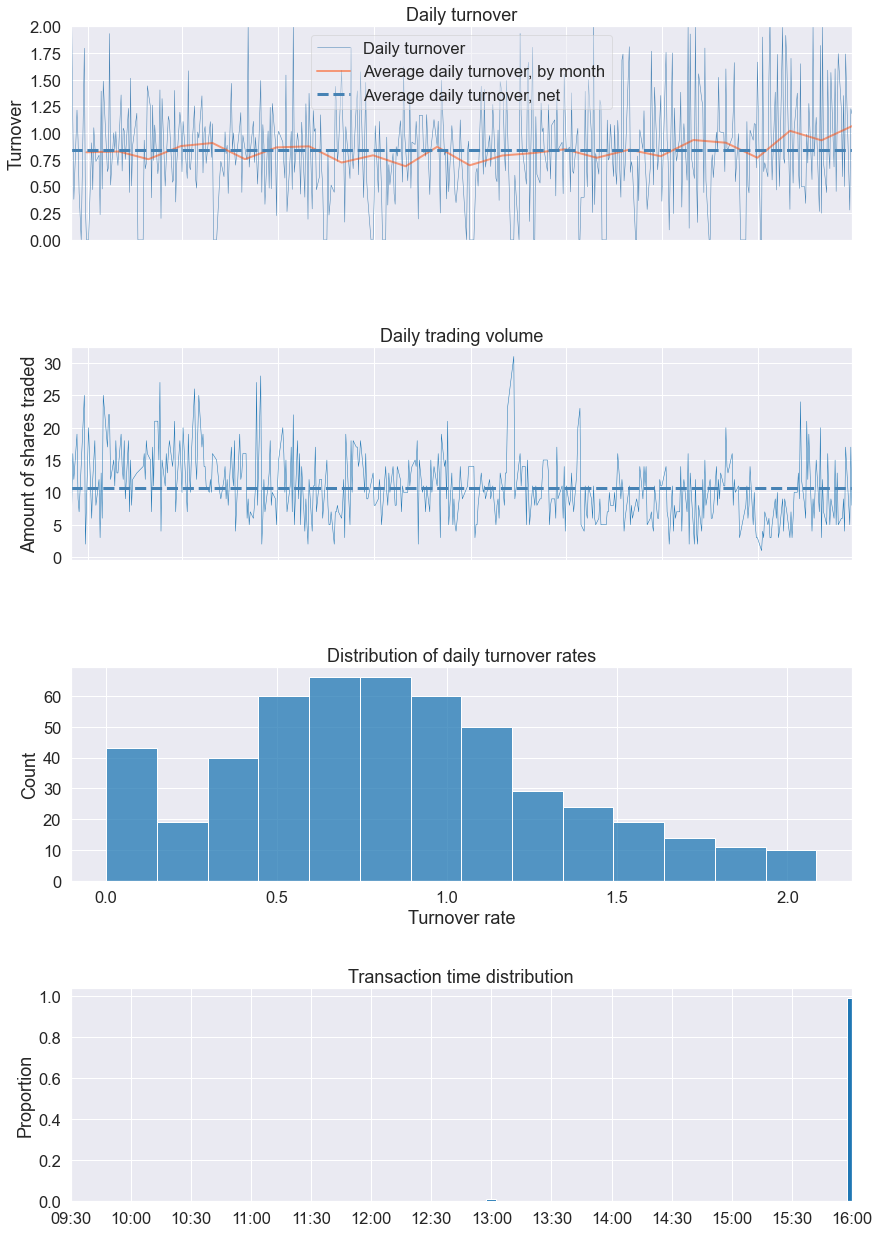

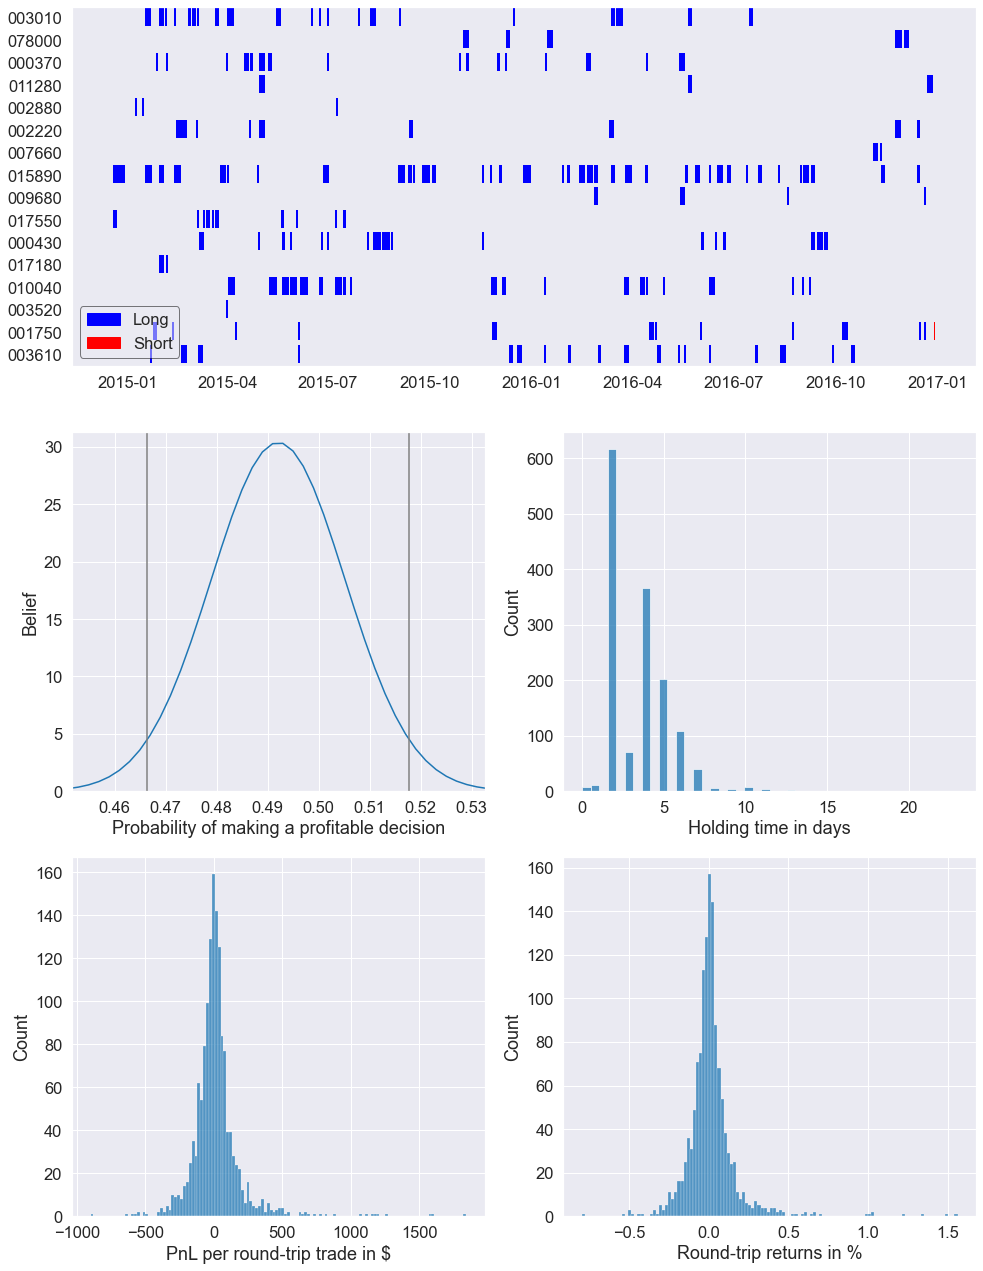

In [116]:
experiment = 'hrp'
returns, positions, transactions = load_results(experiment)

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)

#### Markowitz

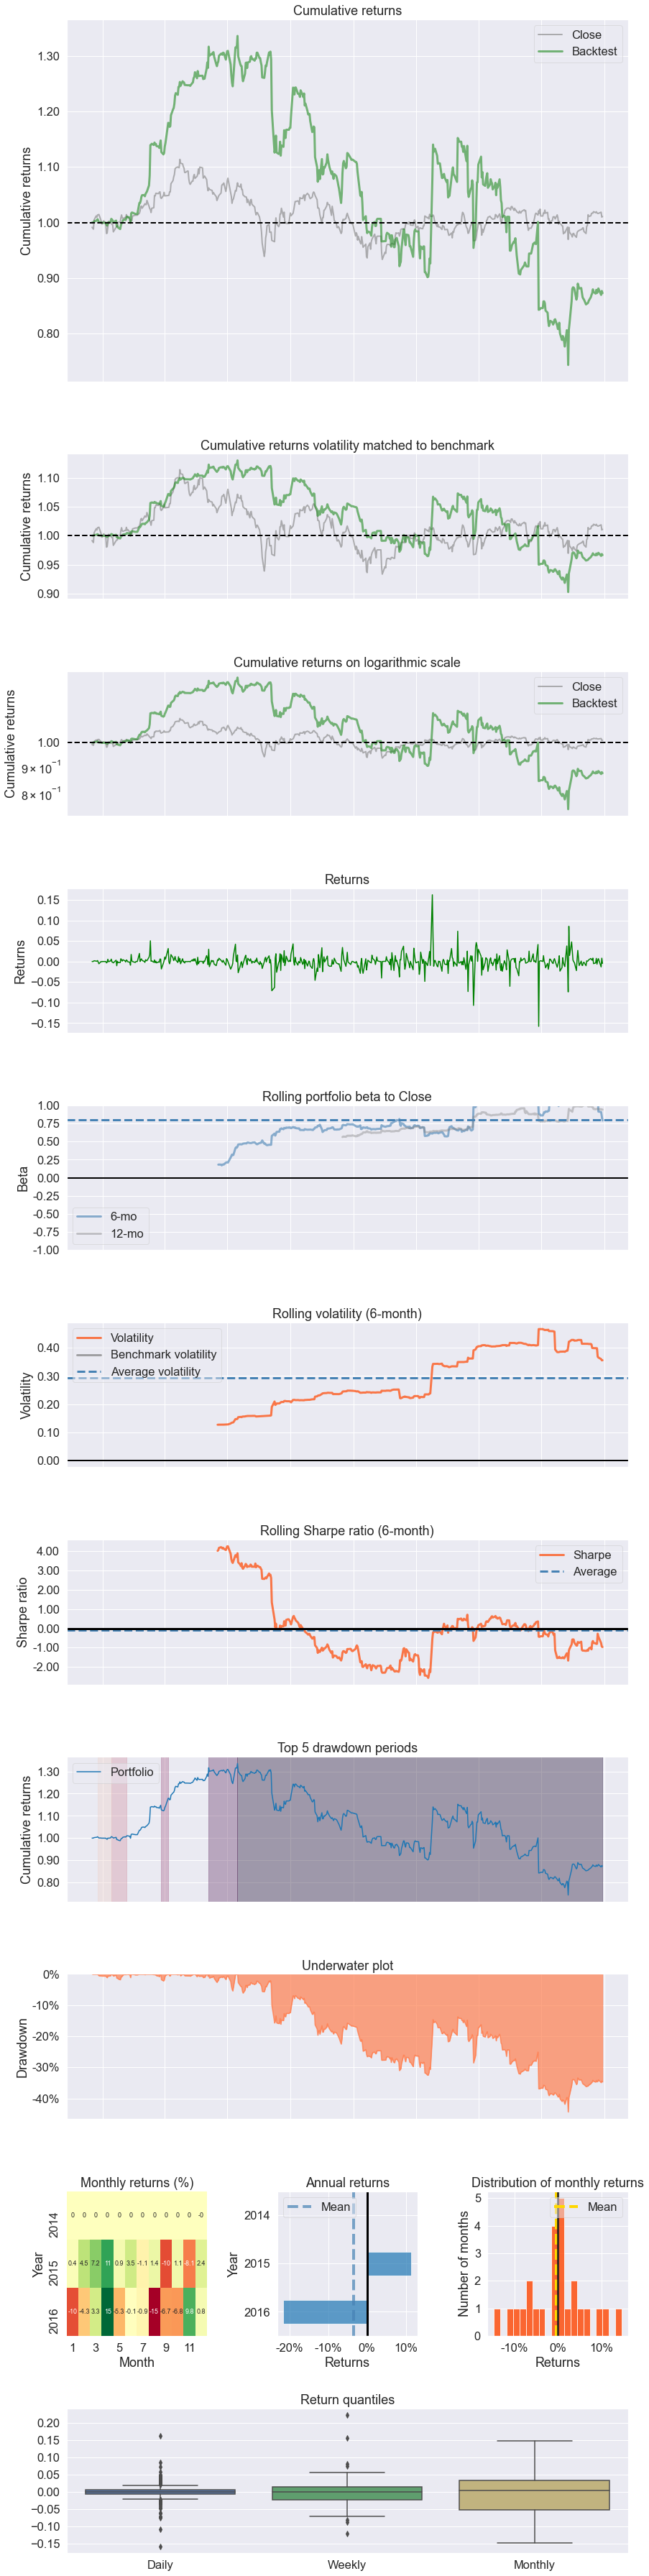

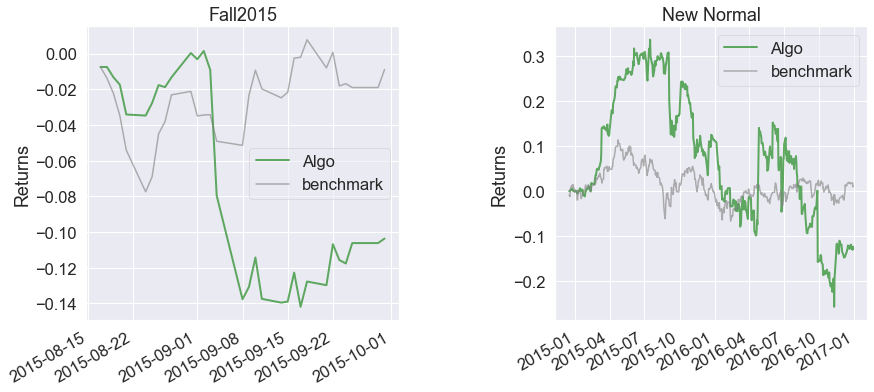

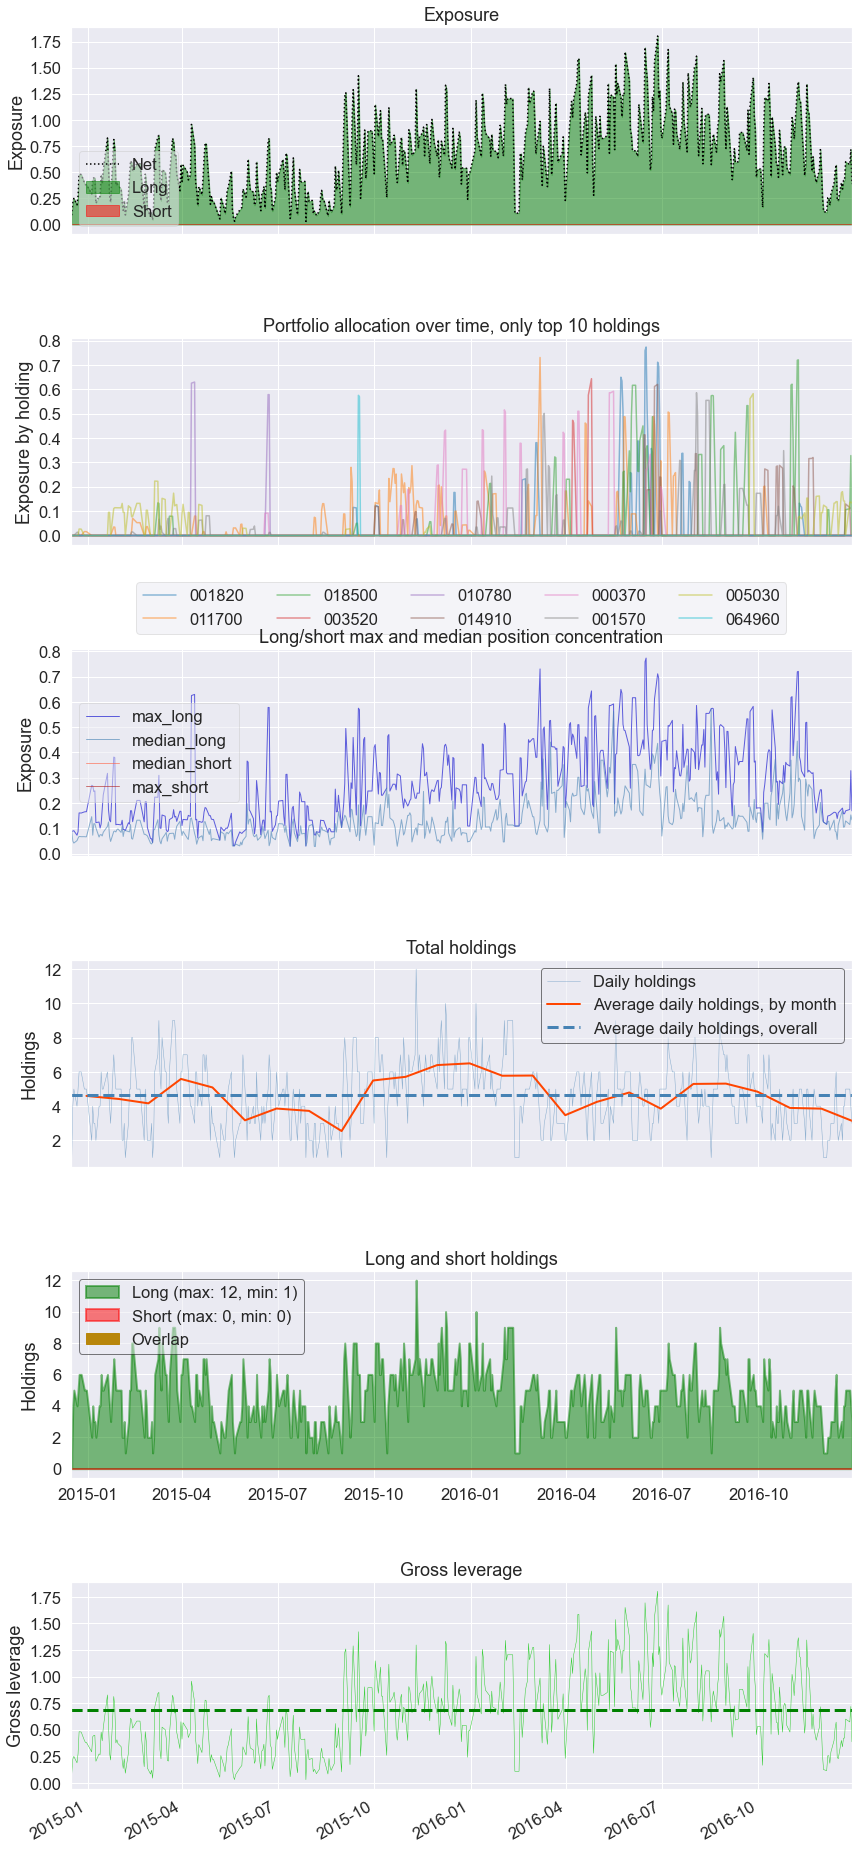

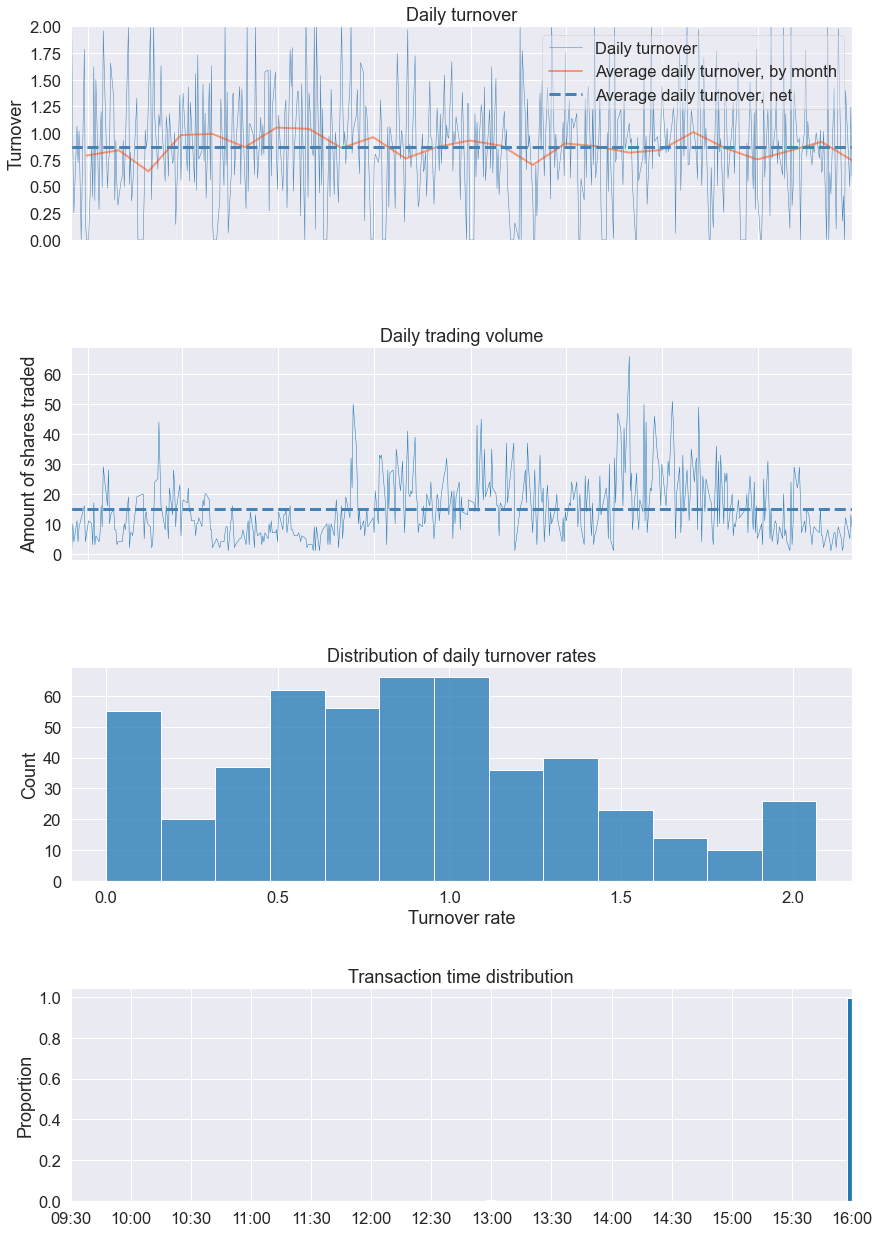

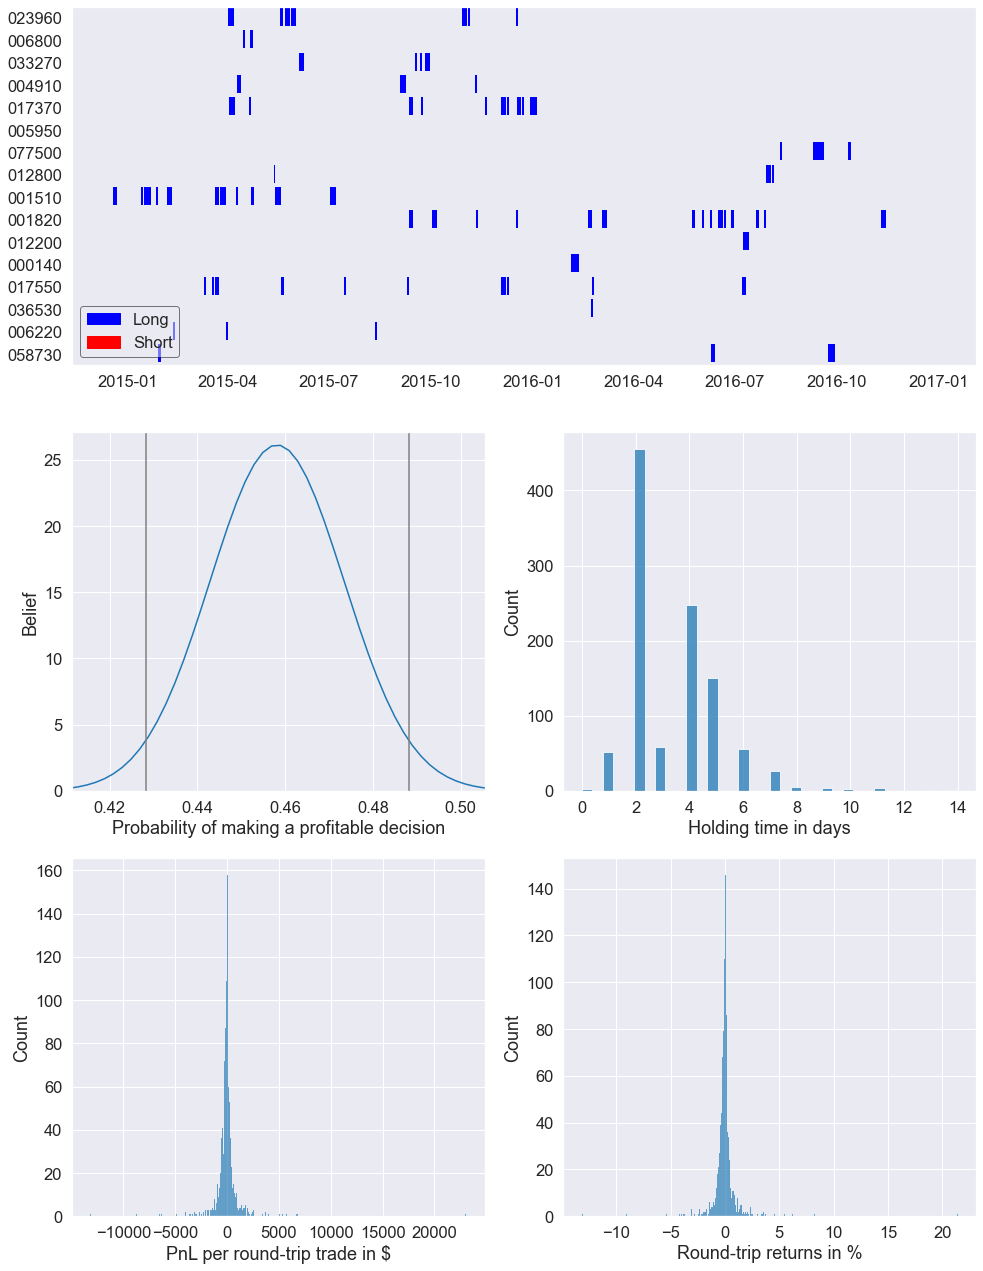

In [118]:
experiment = 'markowitz'
returns, positions, transactions = load_results(experiment)

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)